In [32]:
!pip install opencv-python-headless ftfy regex tqdm torch torchvision torchaudio
!pip install git+https://github.com/openai/CLIP.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-9jxeowp6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-9jxeowp6
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=6cd5d38264c214dbbd55a6109d8c85f3b57b341d39a9c8f2a56a857290f8fb40
  Stored in directory: /tmp/pip-ephem-wheel-cache-93ii00vz/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


In [66]:
from google.colab import files
import cv2, os
import numpy as np

uploaded = files.upload()
video_path = list(uploaded.keys())[0]
clip_dir = "clips"
os.makedirs(clip_dir, exist_ok=True)

def split_video(video_path, output_dir, clip_len=2):
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frames_per_clip = int(fps * clip_len)
    count, clip_idx = 0, 0
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224))
        frames.append(frame)
        count += 1
        if count % frames_per_clip == 0:
            out_path = os.path.join(output_dir, f"clip_{clip_idx}.mp4")
            out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (224, 224))
            for f in frames:
                out.write(f)
            out.release()
            frames = []
            clip_idx += 1
    cap.release()

split_video(video_path, clip_dir)
print("✅ 已完成影片切片")


Saving Aw-3ERGYi9BTRSpCA8C0tKF0IDG0C7LqYzJhS5AaAVQ.mov to Aw-3ERGYi9BTRSpCA8C0tKF0IDG0C7LqYzJhS5AaAVQ (1).mov
✅ 已完成影片切片


In [67]:
import clip
import torch
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


In [69]:
import glob

def extract_clip_features(clip_dir, model, preprocess):
    features = []
    for clip_file in sorted(glob.glob(os.path.join(clip_dir, "*.mp4"))):
        cap = cv2.VideoCapture(clip_file)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            img = preprocess(img).unsqueeze(0).to(device)
            frames.append(img)
        cap.release()
        if frames:
            batch = torch.cat(frames, dim=0)
            with torch.no_grad():
                clip_feat = model.encode_image(batch)
                clip_feat = clip_feat.mean(dim=0).cpu().numpy()
                features.append(clip_feat)
    return np.array(features)

features = extract_clip_features(clip_dir, model, preprocess)
np.save("fronted2.npy", features)
print("✅ 特徵儲存為 fronted2.npy")


✅ 特徵儲存為 fronted2.npy


In [70]:
files.download("fronted2.npy")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

正手特徵總數: 56 筆
反手特徵總數: 4 筆
總資料筆數: 60
訓練集資料筆數: 48
測試集資料筆數: 12


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38928 (\N{CJK UNIFIED IDEOGRAPH-9810}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28858 (\N{CJK UNIFIED IDEOGRAPH-70BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21453 (\N{CJK UNIFIED IDEOGRAPH-53CD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25163 (\N{CJK UNIFIED IDEOGRAPH-624B}) missing from font(s) DejaVu Sans.
  fig.canvas

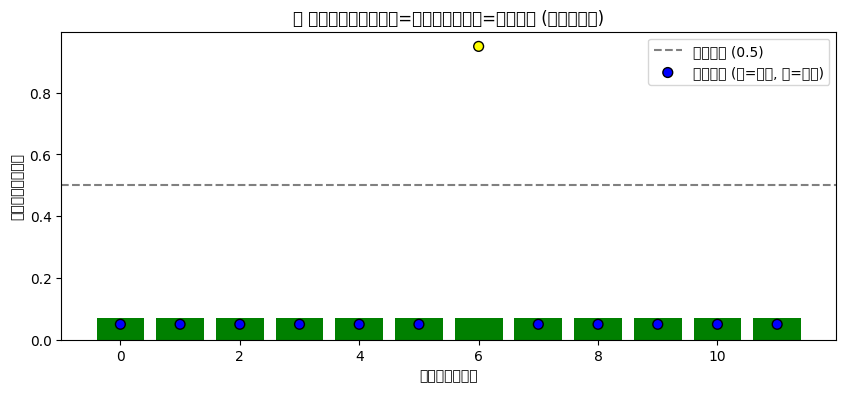

混淆矩陣：
 [[11  0]
 [ 1  0]]

詳細報告：
               precision    recall  f1-score   support

          正手       0.92      1.00      0.96        11
          反手       0.00      0.00      0.00         1

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split # 導入 train_test_split

# --- 1. 載入並合併正手特徵 ---
# 載入所有正手相關的特徵檔案
fh_features_list = []
try:
    fh_features_list.append(np.load("video_features.npy"))
except FileNotFoundError:
    print("找不到 video_features.npy，請確認檔案是否存在。")
try:
    fh_features_list.append(np.load("fronted2.npy"))
except FileNotFoundError:
    print("找不到 fronted2.npy，請確認檔案是否存在。")
try:
    fh_features_list.append(np.load("fronted1.npy"))
except FileNotFoundError:
    print("找不到 fronted1.npy，請確認檔案是否存在。")

if not fh_features_list:
    raise ValueError("沒有載入任何正手特徵檔案。請檢查檔案路徑。")

# 將所有正手特徵垂直堆疊起來
fh_features = np.vstack(fh_features_list)
print(f"正手特徵總數: {len(fh_features)} 筆")


# --- 1. 載入反手特徵 ---
try:
    bh_features = np.load("video_features (1).npy") # 反手特徵
    print(f"反手特徵總數: {len(bh_features)} 筆")
except FileNotFoundError:
    raise FileNotFoundError("找不到 video_features (1).npy，這是反手特徵，請確認檔案是否存在。")


# --- 2. 合併所有資料並產生標籤 ---
X = np.vstack([fh_features, bh_features])
y = np.array([0]*len(fh_features) + [1]*len(bh_features)) # 0=正手, 1=反手
print(f"總資料筆數: {len(X)}")


# --- 3. 數據分割：訓練集與測試集 ---
# 這是非常重要的一步，避免在訓練資料上評估模型
# test_size=0.2 表示 20% 的資料用於測試，random_state 確保每次分割結果一致
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"訓練集資料筆數: {len(X_train)}")
print(f"測試集資料筆數: {len(X_test)}")


# --- 4. 訓練分類器 ---
# 在訓練集上訓練模型
clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

# --- 5. 在測試集上進行預測 ---
y_pred_test = clf.predict(X_test)
y_proba_test = clf.predict_proba(X_test)[:, 1] # 機率值：愈高愈像反手

# --- 6. 繪圖 (使用測試集預測結果) ---
# 繪圖時需要注意，y_test 是真實標籤，y_pred_test 是預測標籤
# 為了正確對應，我們繪製測試集的資料點
plt.figure(figsize=(10, 4))
# 將測試集的真實標籤也考慮進去，以便觀察預測的準確性
colors = []
for i, pred_label in enumerate(y_pred_test):
    if pred_label == 0: # 預測為正手
        colors.append('green')
    else: # 預測為反手
        colors.append('red')

plt.bar(range(len(y_test)), y_proba_test, color=colors)
plt.axhline(0.5, linestyle='--', color='gray', label='決策邊界 (0.5)')

# 為了更容易看出真實標籤，可以在圖上用不同標記或顏色來表示
# 這裡簡單繪製真實標籤，例如：藍點表示真實正手，黃點表示真實反手
# 可以透過調整 y 軸位置來避免覆蓋 bar
real_labels_y_pos = [0.05 if label == 0 else 0.95 for label in y_test] # 小於0.5為正手，大於0.5為反手
plt.scatter(range(len(y_test)), real_labels_y_pos,
            c=['blue' if label == 0 else 'yellow' for label in y_test],
            marker='o', s=50, edgecolors='black', zorder=5,
            label='真實標籤 (藍=正手, 黃=反手)')

plt.title("🎯 動作分類結果：綠條=預測正手，紅條=預測反手 (基於測試集)")
plt.xlabel("測試集片段編號")
plt.ylabel("預測為反手的機率")
plt.legend()
plt.show()


# --- 7. 印出報告 (使用測試集預測結果) ---
cm = confusion_matrix(y_test, y_pred_test)
report = classification_report(y_test, y_pred_test, target_names=["正手", "反手"])
print("混淆矩陣：\n", cm)
print("\n詳細報告：\n", report)

In [47]:
from google.colab import files
uploaded = files.upload()


Saving video_features (1).npy to video_features (1) (1).npy
Saving video_features.npy to video_features (2).npy


In [49]:
import os

# 顯示目前資料夾的所有檔案
for f in os.listdir():
    print(f)


.config
IMG_8668.mov
clips
video_features (1).npy
IMG_8665.MOV
video_features.npy
video_features (2).npy
video_features (1) (1).npy
sample_data


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35222 (\N{CJK UNIFIED IDEOGRAPH-8996}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35258 (\N{CJK UNIFIED IDEOGRAPH-89BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io,

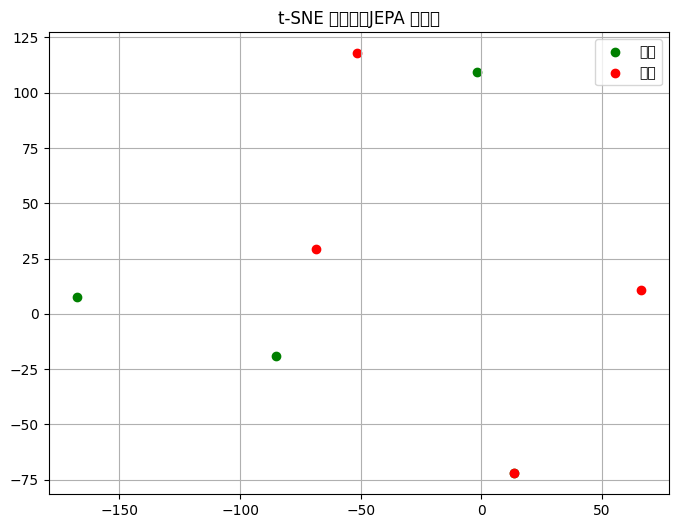

In [50]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 修改這兩個檔名以符合你實際上傳的檔案
fh = np.load("video_features.npy")              # 正手
bh = np.load("video_features (1).npy")          # 反手

# 每類最多取 30 筆來視覺化
sample_n = min(30, len(fh), len(bh))
X = np.concatenate([fh[:sample_n], bh[:sample_n]], axis=0)
y = np.array([0]*sample_n + [1]*sample_n)  # 0=正手, 1=反手

# t-SNE 降維
tsne = TSNE(n_components=2, perplexity=3, n_iter=300, init="pca", learning_rate="auto", random_state=42)
X_embedded = tsne.fit_transform(X)

# 畫圖
plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['green', 'red'], ['正手', '反手']):
    idx = y == label
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], c=color, label=name)
plt.legend()
plt.title("t-SNE 視覺化（JEPA 特徵）")
plt.grid(True)
plt.show()
